In [4]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, set_matplotlib_formats
import myst_nb

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'plotly_mimetype+svg'
pio.templates['book'] = go.layout.Template(
    layout=dict(
        margin=dict(l=10, r=10, t=10, b=10),
        autosize=True,
        width=350, height=250,
    )
)
pio.templates.default = 'seaborn+book'

set_matplotlib_formats('svg')
sns.set()
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
#pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)


/var/folders/s2/cw87rxkn0bx03lwlr3n06skh0001l0/T/ipykernel_77457/3227733056.py:29: DeprecationWarning:

`set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`



In [5]:
_clear = ['bingroup']

def _clear_prop(trace, prop):
    if hasattr(trace, prop):
        trace.update({prop: None})
        
def _clear_props(traces):
    for trace in traces:
        for prop in _clear:
            _clear_prop(trace, prop)

def left_right(left, right, width=700, height=250, **kwargs):
    fig = make_subplots(cols=2, **kwargs)
    fig.update_layout(width=width, height=height)
    
    t1 = list(left.select_traces())
    t2 = list(right.select_traces())
    _clear_props([*t1, *t2])
    fig.add_traces(t1, rows=1, cols=1)
    fig.add_traces(t2, rows=1, cols=2)
    return fig

def margin(fig, **kwargs):
    return fig.update_layout(margin=kwargs)

In [6]:
runners = pd.read_csv('data/cherryBlossomMen.csv')
runnersOver17 = runners[runners["age"] > 17]
runnersOver17 = runnersOver17[runnersOver17["age"] < 76]

dogs = pd.read_csv('data/akc.csv').dropna()
sfh_all = pd.read_csv('data/sfhousing.csv', error_bad_lines=False)

# DAWN
colspecs = [(0,6), (14,29), (33,35), (35, 37), (37, 39), (1213, 1214)]
varNames = ["id", "wt", "age", "sex", "race","type"]
dawn = pd.read_fwf('data/DAWN-Data.txt', colspecs=colspecs, header=None, index_col=0,
                   names = varNames)

/var/folders/s2/cw87rxkn0bx03lwlr3n06skh0001l0/T/ipykernel_77457/306073814.py:6: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.



b'Skipping line 30550: expected 11 fields, saw 12\n'
b'Skipping line 343819: expected 11 fields, saw 12\n'


## Incorporating the Data Design

When you create a visualization, it's important to consider the data scope, especially the data design (see {numref}'Chapter %s ch:data_scope'). Answering the question, How were the data collected?, can impact the plot that we make. These include considerations for the time and place that the data were collected and design used in selecting a sample. In this section, we look at a few examples of how the data scope can inform the kinds of visualizations we make.

## Data Collected over Time


When data are collected over time, we typically make a line plot of points that puts timestamps on the x-axis and feature of interest on the y-axis. As an example, let's revisit the data on San Francisco housing prices. These data were collected from 2003 to 2009 and include the date of the sale. House prices in the US fluctuated tremendously between 2005 and 2012 as the US Housing Bubble caused the market to crash in 2008/2009. So, let's visualize the sale prices as a time series. To do this, we plot the median house price over time (this is a form of smoothing, see {numref}'Section %s sec:viz_smoothing'). Why use the median? Home prices tend to be highly skewed because of a few outliers. We saw this phenomenon when viewing the distribution of sale price.

In [7]:
def parse_dates(sfh):
    dates = pd.to_datetime(sfh['date'], infer_datetime_format=True)
    return sfh.assign(date=dates).set_index('date')

percs=[10,30,50,70,90]


def find_percentiles(series):
    prices = np.percentile(series, percs, interpolation='lower')
    return pd.Series(prices, index=percs)

monthly_percentiles = (sfh_all
 .pipe(parse_dates)
 .resample('M')
 ['price']
 .apply(find_percentiles)
 .reset_index()
 .rename(columns={'level_1': 'percentile'})
)

rel_prices = (monthly_percentiles
 .groupby('percentile')
 ['price']
 .transform(lambda s: s / s.iloc[0])
)

rel_percentiles = monthly_percentiles.assign(rel_price=rel_prices)
rel_percentiles

,date,percentile,price,rel_price
0,2003-04-30,10,255000.0,1.000000
1,2003-04-30,30,340000.0,1.000000
2,2003-04-30,50,421000.0,1.000000
...,...,...,...,...
337,2008-11-30,50,365000.0,0.866983
338,2008-11-30,70,515000.0,0.962617
339,2008-11-30,90,841500.0,1.069250


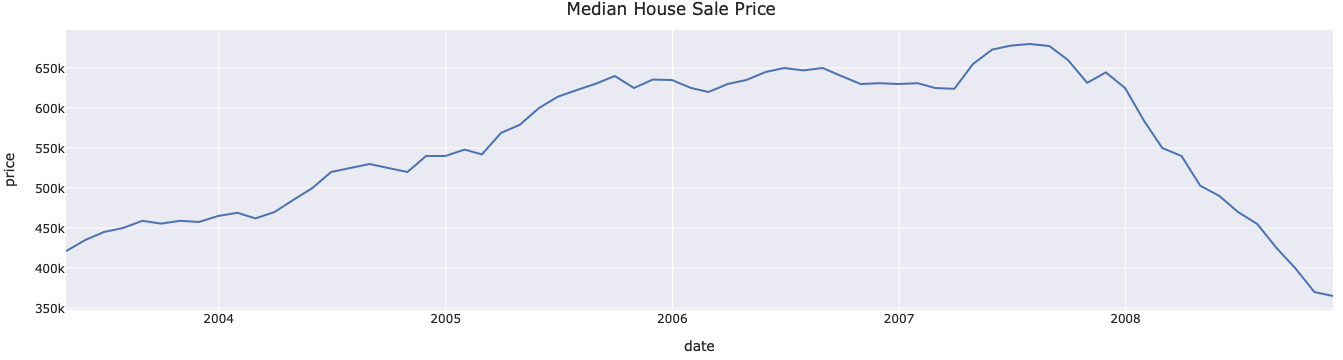

In [9]:
medians = rel_percentiles.query('percentile==50')
fig = px.line(medians, x='date', y='price',
              title = 'Median House Sale Price',
              width=600, height=250)
margin(fig,t=30)

This plot shows the rise in prices from 2003 to 2007 and the fall in 2008. But we can show more information by plotting a few other percentiles instead of just the median. In the plot below, we draw separate lines for the 10th, 30th, 50th (median), 70th, and 90th percentile sale prices.

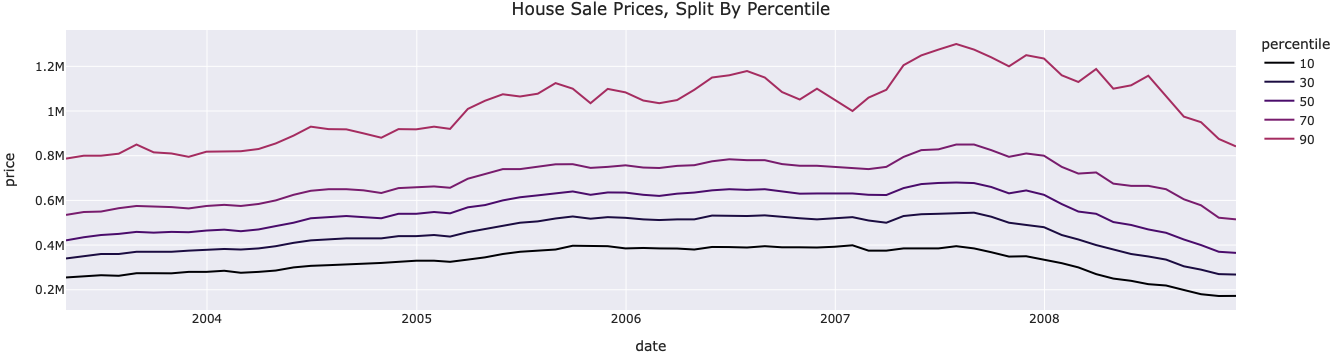

In [10]:
fig = px.line(rel_percentiles, x='date', y='price', color='percentile',
              color_discrete_sequence=plotly.express.colors.sequential.Inferno,
              title='House Sale Prices, Split By Percentile',
              width=600, height=250)
margin(fig, t=30)

When we examine prices over time, we typically need to adjust for inflation so that the comparisons are on the same footing. In addition to adjusting for inflation, let's plot the prices relative to the starting price in 2003 for each of the percentiles. This means that all the lines will start at y=1 in 2003. This normalization lets us see how the housing crash affected homes in the different parts of the market.

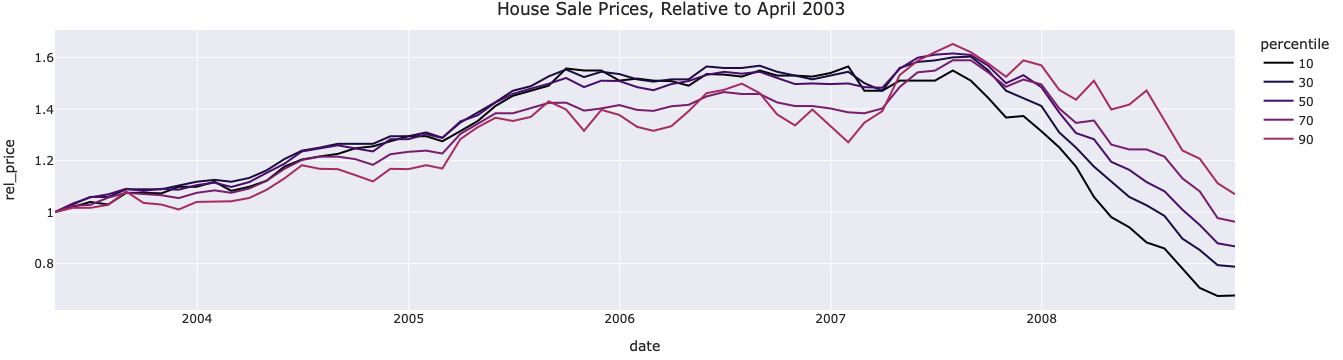

In [11]:
## Adjust for inflation 2003 = 1 to 2009-16.60
infl_2003 = [1, 2.66, 6.14, 9.57, 12.69,17.01, 16.60]

fig = px.line(rel_percentiles, x='date', y='rel_price', color='percentile',
              color_discrete_sequence=plotly.express.colors.sequential.Inferno,
              title='House Sale Prices, Relative to April 2003',
              width=600, height=250)
margin(fig, t=30)

The plot above shows that higher-end homes weren't as affected by the crash. At the end of 2008, the 90th percentile home prices were nearly the same as the 2003 prices. But the 10th percentile home prices dropped by nearly a third. Applying this bit of domain knowledge helps reveal trends in the data that we might otherwise miss, and shows how we can use the data design to improve a visualization.

## Observational Studies
We need to be particularly cautious with data that do not form a census or scientific sample. We should also take care with cross-sectional studies, whether from a census or scientific sample, as we'll show by revisisting the Cherry Blossom Ten-Mile Run example. Earlier in this chapter, we made a smoothed curve to examine the relationship between race time and age. We reproduce this plot below.

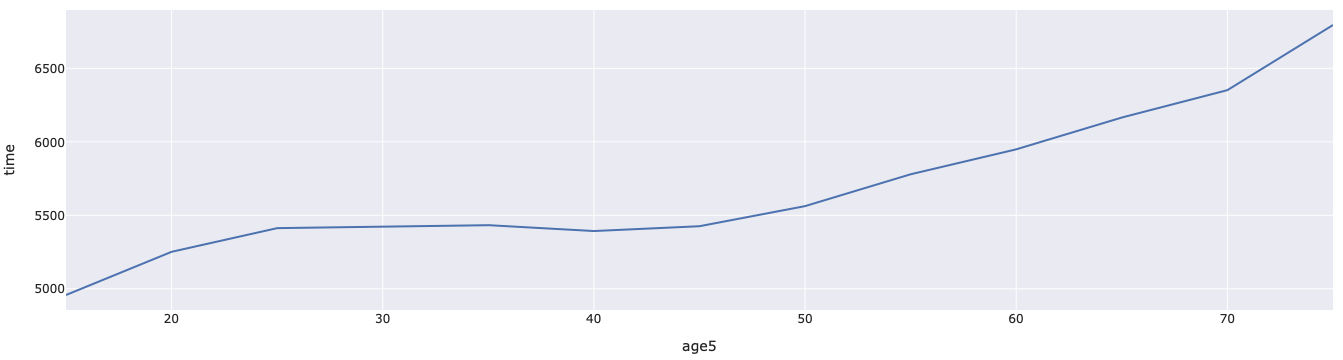

In [12]:
times = (
    runnersOver17.assign(age5=runnersOver17['age'] // 5 * 5)
    .groupby('age5')
    ['time']
    .mean()
    .reset_index()
)

px.line(times, x='age5', y='time', width=350, height=250)

It's tempting to look at this plot and say something like: a runner at age 20 can expect to have similar race times at age 40. However, this is a cross-sectional study, not a longitudinal study. For instance, the 25-year-old runners in a race are different people than the 40-year-old runners. These two groups could be different in ways that would affect the relationship between race time and age. As a group, the 40-year-olds in the race are likely to be more fit for their age than the 25-year-olds. In other words, the data design doesn't let us make conclusions about individual runners. The visualization isn't wrong, but we should be careful about the conclusions we draw from it.

The design is even more complex because we have race results from many years. Each year forms a cohort, a group of racers, and from one year to the next, the cohort changes. We can make a useful plot by conditioning on year, as shown in the plot below. Here, we've only plotted the data for the years 1999, 2005, and 2010.

In [13]:
few = (runnersOver17.assign(age5=runnersOver17['age'] // 5 * 5)
       .query('year in [1999, 2005, 2010]')
       .groupby(['year', 'age5'])
       ['time']
       .median()
       .reset_index()
      )

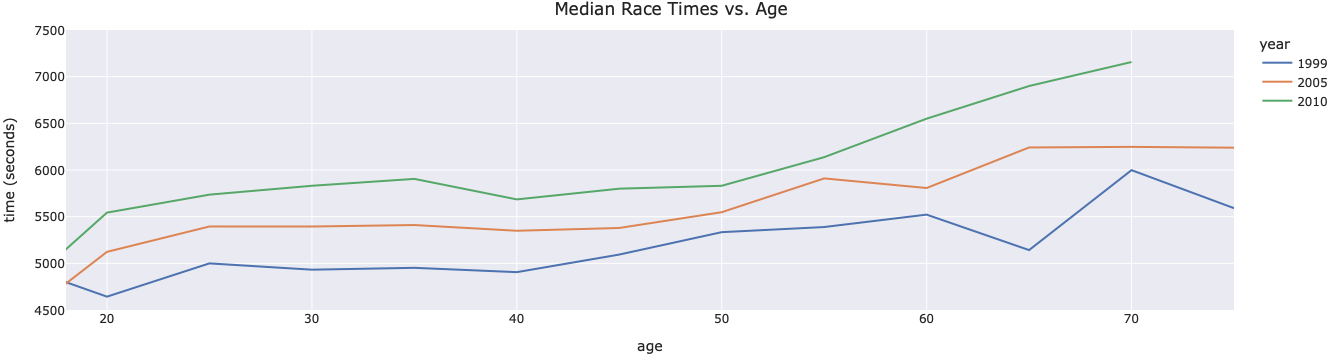

In [14]:
fig = px.line(few, x='age5', y='time', color='year',
              title='Median Race Times vs. Age',
              width=450, height=250,
             )
fig.update_xaxes(range=[18, 75], title="age")
fig.update_yaxes(range=[4500, 7500], title="time (seconds)")
margin(fig, t=30)

We see that the median race times in 2010 were higher at every age group than the times for the runners in 2005, and in turn, the 2005 runners times were higher that for the runners in 1999. It's interesting that race times have slowed over the years. This is quite likely due to the increased popularity of the race and so higher participation from novice runners in the more recent years. This example showed how we need to be aware of the data scope when interpreting patterns. We also need to keep data scope in mind with scientific studies. This is the topic of the next section.

## Unequal Sampling
In a scientific study, we should consider the sample design because it can affect our plots. Some samples draw individuals at unequal rates. That is, if men have been sampled at twice the rate of women, we should avoid making even a simple plot like a histogram until we adjust for the uneven gender ratio.

We have seen an example of a scientific study in {numref}'Chapter %s ch:files' and {numref}'Chapter %s ch:wrangling', the Drug Abuse Warning Network (DAWN) survey. These data are from a complex randomized study of drug-related emergency room visits, and each record comes with its weight that we must use in order to accurately represent the emergency room visit in the population. The two bar plots below show the distribution of the type of ER visit. The one on the left doesn't use the weights and the one on the right does.

<AxesSubplot:xlabel='type'>

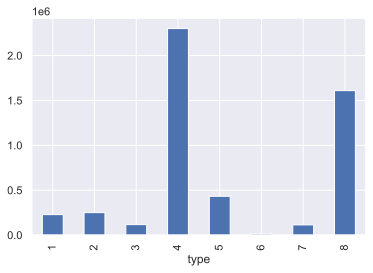

In [15]:
dawn_type = dawn.groupby('type')['wt'].sum()



types = {1:'suicide attempt', 2:'detox', 3:'alcohol', 4:'adverse reaction',
        5:'overmedication', 6:'malicious poisoning', 7:'accidental ingestion', 8:'other'}

#need to convert to plotly; add labels; order and normalize bars; put the two plots side-by-side

dawn_type.plot(kind='bar')

<AxesSubplot:>

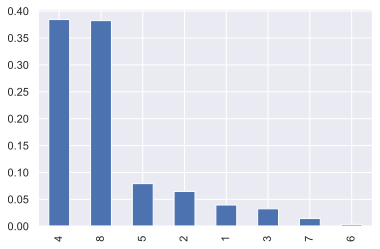

In [16]:
dawn_cts = dawn['type'].value_counts(normalize=True)
dawn_cts.plot(kind='bar')

In the unweighted bar plot, it appears that the "Other" category is as frequent as the "Adverse Reaction" category. However, when weighted, Other drops to about 60\% of Adverse Reaction. And, we see other changes in the order and size of the types of admission to the ER. Ignoring sampling weights can give a misleading presentation of a distribution. Whether for a histogram, bar plot, boxplot, two-dimensional contour, or smooth curve we need to use the weights to get a representative plot. Another aspect of the data scope that can impact our choice of plots is where the data are collected. This is the topic of the next section.

## Geographic Data
When our dataset contains geographic information like latitudes and longitudes, we should consider making a map in addition to the typical plots for numeric data like histograms and scatter plots. For example, the plot below shows the locations for US Air Quality sensors, which are the focus of the case study in {numref}Chapter %s <ch:pa>.

In [19]:
def rollup_dup_sites(df):
    return (
        df.groupby('AQS_Site_ID')
        .first()
        .reset_index()
    )

def subset_aqs(df):
    subset = df[['AQS_Site_ID', 'Latitude', 'Longitude']]
    subset.columns = ['site_id', 'lat', 'lon']
    return subset

aqs_sites = (pd.read_csv('data/list_of_aqs_sites.csv')
             .pipe(rollup_dup_sites)
             .pipe(subset_aqs))
aqs_sites

,site_id,lat,lon
0,01-003-0010,30.497478,-87.880258
1,01-027-0001,33.284928,-85.803608
2,01-049-1003,34.288567,-85.969858
...,...,...,...
918,56-039-1013,44.373056,-110.830833
919,80-002-0012,32.629225,-115.447769
920,80-002-0014,32.633671,-115.504995


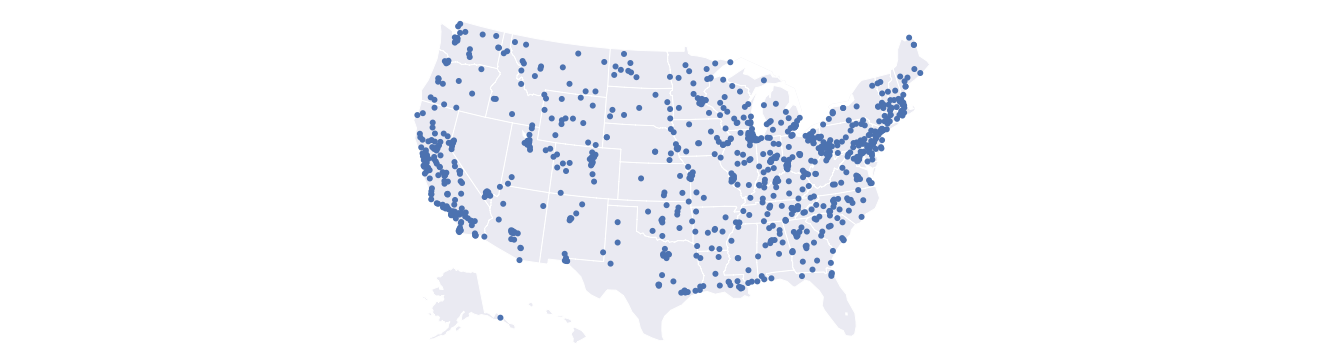

In [20]:
fig = px.scatter_geo(aqs_sites, lat='lat', lon='lon',
                     locationmode='USA-states', 
                     scope='usa',
                     width=550, height=300)
fig


Notice that there are many more points in California and the Eastern Seaboard. A simple histogram of XXX, would be difficult to interpret because the distribution doesn't reflect the abundance of measurmeents on the east and west coasts. To help remedy this problem, we can add XXX to the map.

In this section, we explored ways to incorporate the data scope into a plot. We considered where and when the data were collected and the sampling design. Maps are useful representations of geographic data, and time-series plots are useful when data have a time component. We also saw how the sample desgin affects the kinds of plots we make and their interpretations. In the next section, we'll discuss principles for adding useful context to plots.